In [114]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from d2l import torch as d2l
import time
from sklearn.metrics import f1_score
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [115]:
path = "F:/Document/France/ENPC/Cours/S5/Projet/data/"
os.chdir(path)

In [189]:
data_2_test = np.load("data_2_test.npy")
data_3_test = np.load("data_3_test.npy")
data_4_test = np.load("data_4_test.npy")
data_augmented_2 = np.load("data_augmented_2.npy")
data_augmented_3 = np.load("data_augmented_3.npy")
data_augmented_4 = np.load("data_augmented_4.npy")
labels_2 = np.load("labels_2.npy")
labels_3 = np.load("labels_3.npy")
labels_4 = np.load("labels_4.npy")

In [117]:
df_data = pd.read_csv("datadone.csv", header=None)
np_data = df_data.values
np_vitesse = np_data[:, :614]
np_frf = np_data[:, 614:1228]
np_fft = np_data[:, 1228:1535]
np_classe = np_data[:, 1535:]

In [118]:
ts_vitesse = torch.tensor(np_vitesse, dtype=torch.float32).reshape(np_vitesse.shape[0], 1, np_vitesse.shape[1])
ts_frf = torch.tensor(np_frf, dtype=torch.float32).reshape(np_frf.shape[0], 1, np_frf.shape[1])
ts_classe = torch.tensor(np_classe, dtype=torch.float32)

In [119]:
np_label = np_classe.argmax(axis=1)
index_0 = np.where(np_label == 0)
index_1 = np.where(np_label == 1)
index_2 = np.where(np_label == 2)
index_3 = np.where(np_label == 3)
index_4 = np.where(np_label == 4)

In [120]:
ts_frf_0 = ts_frf[index_0]
labels_0 = np_label[index_0]
ts_frf_1 = ts_frf[index_1]
labels_1 = np_label[index_1]

In [121]:
threshold0 = int(0.8 * ts_frf_0.shape[0])
threshold1 = int(0.8 * ts_frf_1.shape[0]) 
ts_frf_0_train = ts_frf_0[:threshold0]
labels_0_train = labels_0[:threshold0]
ts_frf_0_test = ts_frf_0[threshold0:]
labels_0_test = labels_0[threshold0:]
ts_frf_1_train = ts_frf_1[:threshold1]
labels_1_train = labels_1[:threshold1]
ts_frf_1_test = ts_frf_1[threshold1:]
labels_1_test = labels_1[threshold1:]

In [191]:
ts_frf_2_aug = torch.tensor(data_augmented_2[:1000, :, 1], dtype=torch.float32).reshape(1000, 1, data_augmented_2.shape[1])
ts_frf_3_aug = torch.tensor(data_augmented_3[:1000, :, 1], dtype=torch.float32).reshape(1000, 1, data_augmented_3.shape[1])
ts_frf_4_aug = torch.tensor(data_augmented_4[:1000, :, 1], dtype=torch.float32).reshape(1000, 1, data_augmented_4.shape[1])

In [192]:
ts_train_frf = torch.concat((ts_frf_0_train, ts_frf_1_train, ts_frf_2_aug, ts_frf_3_aug, ts_frf_4_aug), axis=0)
train_label = np.concatenate((labels_0_train, labels_1_train, labels_2[:1000], labels_3[:1000], labels_4[:1000]), axis=0, dtype=np.float64)
ts_train_label =  torch.tensor(pd.get_dummies(train_label).values, dtype=torch.float32)

In [193]:
ts_frf_2_test = torch.tensor(data_2_test[:, :, 1], dtype=torch.float32).reshape(data_2_test.shape[0], 1, data_2_test.shape[1])
ts_frf_3_test = torch.tensor(data_3_test[:, :, 1], dtype=torch.float32).reshape(data_3_test.shape[0], 1, data_3_test.shape[1])
ts_frf_4_test = torch.tensor(data_4_test[:, :, 1], dtype=torch.float32).reshape(data_4_test.shape[0], 1, data_4_test.shape[1])

In [194]:
labels_2_test = 2.0 * np.ones(ts_frf_2_test.shape[0])
labels_3_test = 3.0 * np.ones(ts_frf_3_test.shape[0])
labels_4_test = 4.0 * np.ones(ts_frf_4_test.shape[0])

In [195]:
ts_test_frf = torch.concat((ts_frf_0_test, ts_frf_1_test, ts_frf_2_test, ts_frf_3_test, ts_frf_4_test), axis=0)
test_label = np.concatenate((labels_0_test, labels_1_test, labels_2_test, labels_3_test, labels_4_test), axis=0)
ts_test_label =  torch.tensor(pd.get_dummies(test_label).values, dtype=torch.float32)

In [196]:
index_train = np.arange(ts_train_frf.shape[0])
np.random.shuffle(index_train)
ts_train_frf = ts_train_frf[index_train]
ts_train_label = ts_train_label[index_train]

In [199]:
thresholdvalid = int(0.75 * ts_train_frf.shape[0])
X_train = ts_train_frf[:thresholdvalid]
Y_train = ts_train_label[:thresholdvalid]
X_valid = ts_train_frf[thresholdvalid:]
Y_valid = ts_train_label[thresholdvalid:]
X_test = ts_test_frf
Y_test = ts_test_label

In [211]:
X_test = torch.load('X_test_f.pt').detach()
Y_test = torch.load('Y_test.pt')

In [200]:
class Residual1d(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv1d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))  # conv1 +batchnorm + relu
        Y = self.bn2(self.conv2(Y))  # conv2 + batchnorm
        if self.conv3:
            X = self.conv3(X)
        Y += X   # residual + base
        return F.relu(Y)

def resnet_block1d(input_channels, num_channels, num_residuals,
                   first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual1d(input_channels, num_channels,
                                  use_1x1conv=True, strides=2))
        else:
            blk.append(Residual1d(num_channels, num_channels))
    return blk

# stage1, length / 2
b1 = nn.Sequential(nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm1d(16), nn.ReLU(),
                    nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
# stage2, keep form
b2 = nn.Sequential(*resnet_block1d(16, 16, 2, first_block=True))
# stage3, channel * 2
b3 = nn.Sequential(*resnet_block1d(16, 32, 2))
# stage4, channel * 2, length / 2
b4 = nn.Sequential(*resnet_block1d(32, 64, 2))
b5 = nn.Sequential(*resnet_block1d(64, 128, 2))
resnet_f = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(128, 5))

In [201]:
def try_gpu(i=0):
    """if gpu exist, return gpu(i), otherwise, return cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    y = y.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    if not device: 
        device = try_gpu()
    metric = d2l.Accumulator(2) 
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y), y.shape[0])
    return metric[0] / metric[1]

def train_accuracy(net, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    train_iter = d2l.load_array((X_train, Y_train), batch_size)
    test_iter = d2l.load_array((X_valid, Y_valid), batch_size,
                               is_train=False)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
num_epochs, lr, weight_decay, batch_size, device = 10, 1e-3, 0, 64, try_gpu()

In [202]:
def plot_confusion_matrix(cm):
    df_cm = pd.DataFrame(cm / np.sum(cm, axis=1).reshape(-1, 1), range(5), range(5))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

def evaluate_net(net, X_test, Y_test):
    net.cpu()
    Y_pred = net(X_test)
    np_Y_pred = Y_pred.argmax(axis=1).numpy()
    np_Y_test = Y_test.argmax(axis=1).numpy()
    f1s = f1_score(np_Y_test, np_Y_pred, average='weighted')
    print(f'F1 score: {f1s:.3f}')
    cm = confusion_matrix(np_Y_test, np_Y_pred)
    plot_confusion_matrix(cm)

loss 0.172, train acc 0.936, test acc 0.931
1747.1 examples/sec on cuda:0


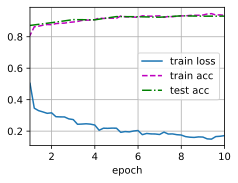

In [203]:
train_accuracy(resnet_f, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

F1 score: 0.926


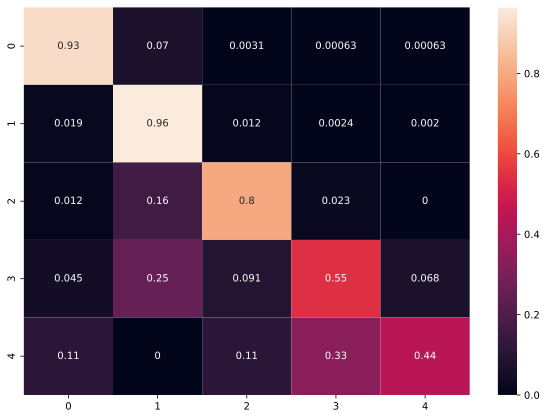

In [204]:
evaluate_net(resnet_f, X_test, Y_test)

In [213]:
ts_frf_2_aug = torch.tensor(data_augmented_2[:2000, :, 1], dtype=torch.float32).reshape(2000, 1, data_augmented_2.shape[1])
ts_frf_3_aug = torch.tensor(data_augmented_3[:2000, :, 1], dtype=torch.float32).reshape(2000, 1, data_augmented_3.shape[1])
ts_frf_4_aug = torch.tensor(data_augmented_4[:2000, :, 1], dtype=torch.float32).reshape(2000, 1, data_augmented_4.shape[1])

ts_train_frf = torch.concat((ts_frf_0_train, ts_frf_1_train, ts_frf_2_aug, ts_frf_3_aug, ts_frf_4_aug), axis=0)
train_label = np.concatenate((labels_0_train, labels_1_train, labels_2[:2000], labels_3[:2000], labels_4[:2000]), axis=0, dtype=np.float64)
ts_train_label =  torch.tensor(pd.get_dummies(train_label).values, dtype=torch.float32)

index_train = np.arange(ts_train_frf.shape[0])
np.random.shuffle(index_train)
ts_train_frf = ts_train_frf[index_train]
ts_train_label = ts_train_label[index_train]

thresholdvalid = int(0.75 * ts_train_frf.shape[0])
X_train = ts_train_frf[:thresholdvalid]
Y_train = ts_train_label[:thresholdvalid]
X_valid = ts_train_frf[thresholdvalid:]
Y_valid = ts_train_label[thresholdvalid:]

loss 0.060, train acc 0.977, test acc 0.949
1452.6 examples/sec on cuda:0


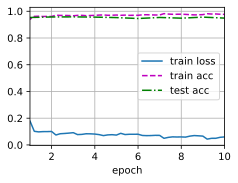

In [214]:
train_accuracy(resnet_f, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

F1 score: 0.918


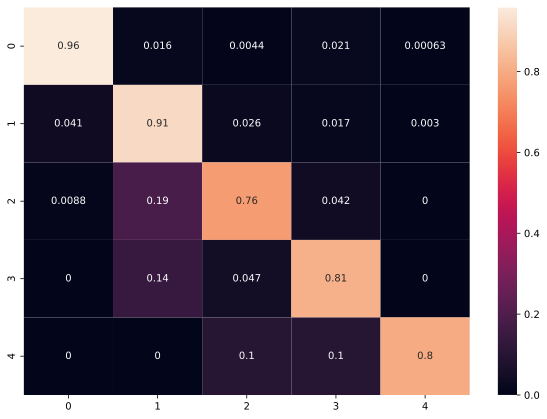

In [215]:
evaluate_net(resnet_f, X_test, Y_test)

In [208]:
ts_frf_2_aug = torch.tensor(data_augmented_2[:, :, 1], dtype=torch.float32).reshape(data_augmented_2.shape[0], 1, data_augmented_2.shape[1])
ts_frf_3_aug = torch.tensor(data_augmented_3[:, :, 1], dtype=torch.float32).reshape(data_augmented_3.shape[0], 1, data_augmented_3.shape[1])
ts_frf_4_aug = torch.tensor(data_augmented_4[:, :, 1], dtype=torch.float32).reshape(data_augmented_4.shape[0], 1, data_augmented_4.shape[1])

ts_train_frf = torch.concat((ts_frf_0_train, ts_frf_1_train, ts_frf_2_aug, ts_frf_3_aug, ts_frf_4_aug), axis=0)
train_label = np.concatenate((labels_0_train, labels_1_train, labels_2, labels_3, labels_4), axis=0, dtype=np.float64)
ts_train_label =  torch.tensor(pd.get_dummies(train_label).values, dtype=torch.float32)

index_train = np.arange(ts_train_frf.shape[0])
np.random.shuffle(index_train)
ts_train_frf = ts_train_frf[index_train]
ts_train_label = ts_train_label[index_train]

thresholdvalid = int(0.75 * ts_train_frf.shape[0])
X_train = ts_train_frf[:thresholdvalid]
Y_train = ts_train_label[:thresholdvalid]
X_valid = ts_train_frf[thresholdvalid:]
Y_valid = ts_train_label[thresholdvalid:]

loss 0.084, train acc 0.968, test acc 0.954
1912.5 examples/sec on cuda:0


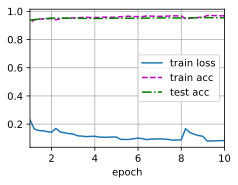

In [209]:
train_accuracy(resnet_f, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

F1 score: 0.892


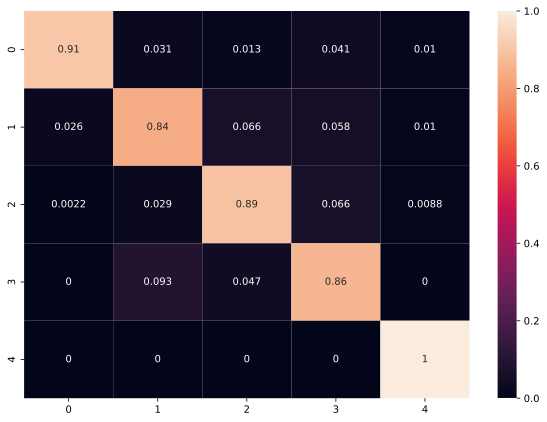

In [212]:
evaluate_net(resnet_f, X_test, Y_test)